In [99]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from utils import gen_feed_func, gen_vecs
from data_feed import BasicDataFeed

import itertools
import random

In [100]:
n_items = 16
t_present = 0.5
pause = 0.1
D = 16
dt = 0.001
similarity = 0.95

recog_neurons = 500
seed = 0
spikes_synapse = 0.005

t_train = t_present*n_items
t_test = 2*(t_present+pause)*n_items

In [101]:
vocab = spa.Vocabulary(D)

targ_class = []

stim_vecs = gen_vecs(n_items, D, similarity)
stim_lbl = []

for v_i, vec in enumerate(stim_vecs):
    lbl = "S%d" % v_i
    stim_lbl.append(lbl)
    vocab.add(lbl, vec)

    targ = np.zeros(n_items)
    targ[v_i] = 1
    targ_class.append(targ)

print(stim_lbl)

for s1, s2 in itertools.combinations(stim_lbl, 2):
    print(np.dot(vocab.parse(s1).v, vocab.parse(s2).v))

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15']
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95


In [102]:
def vocab_feed(idx, t):
    return vocab.parse(stim_lbl[idx]).v

# Baseline

In [130]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    
    nengo.Connection(in_nd, recog, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [131]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:01.                                                                                                                                
Simulating finished in 0:00:02.                                                                                                                              


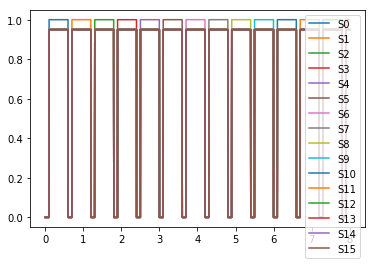

In [132]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

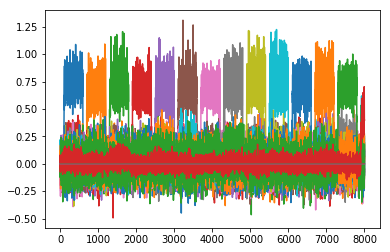

In [133]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [134]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    
    nengo.Connection(in_nd, recog, synapse=None)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [136]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                                                                                                
Simulating finished in 0:00:05.                                                                                                                              


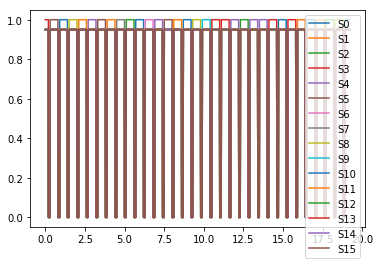

In [137]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

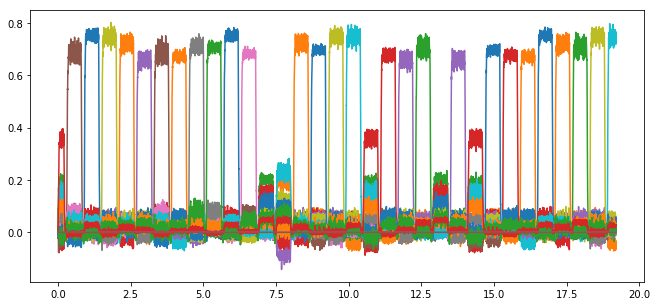

In [138]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), sim.data[p_out])

# Associative Memory Baseline

In [75]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog.input, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_out = nengo.Probe(recog.output, synapse=0.01)

In [76]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                                                                                                
Simulating finished in 0:00:04.                                                                                                                              


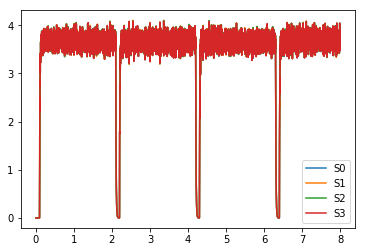

In [77]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], stim_vecs))
plt.legend(stim_lbl)

# Decoding directly from oscillator

In [139]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [140]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:02.                                                                                                                                
Simulating finished in 0:00:06.                                                                                                                              


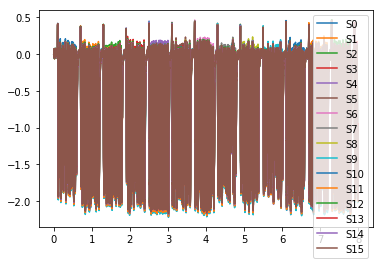

In [141]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

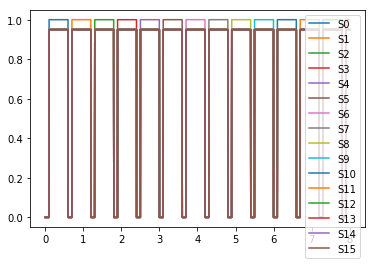

In [142]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

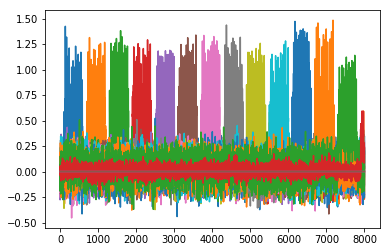

In [143]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [144]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [145]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:02.                                                                                                                                
Simulating finished in 0:00:36.                                                                                                                              


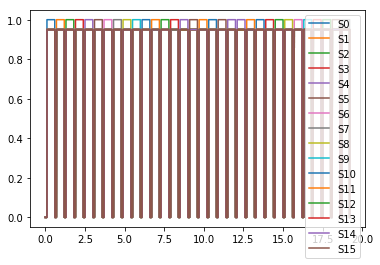

In [146]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

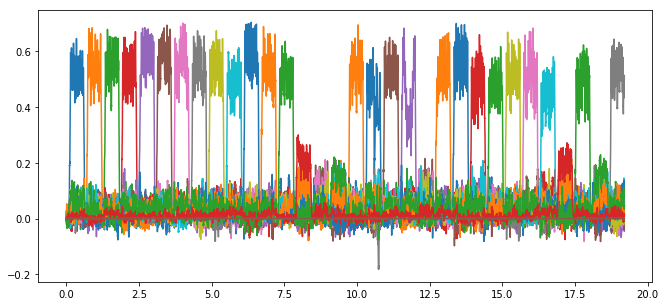

In [147]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), sim.data[p_out])

# Decoding directly from oscillator with pos gain

In [121]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=10, seed=seed)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [122]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:02.                                                                                                                                
Simulating finished in 0:00:16.                                                                                                                              


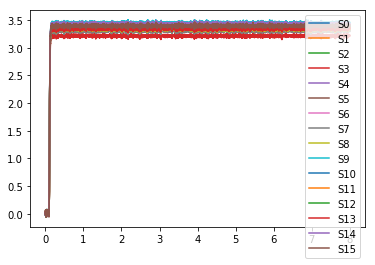

In [123]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

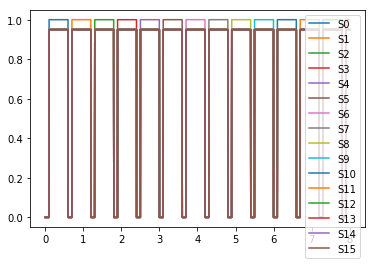

In [124]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

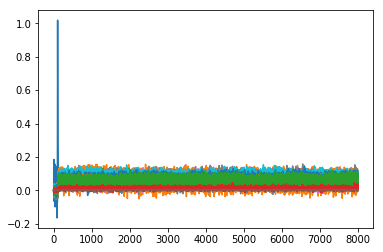

In [125]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [126]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=10, seed=seed)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [127]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                                                                                                
Simulating finished in 0:00:34.                                                                                                                              


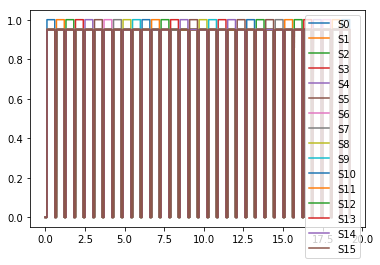

In [128]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

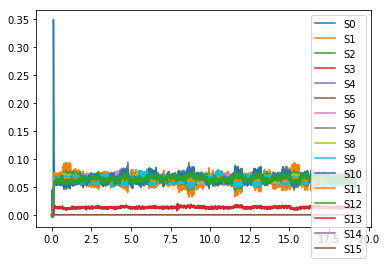

In [129]:
plt.plot(sim.trange(), sim.data[p_out])
plt.legend(stim_lbl)

# Decoding from temporal network

Not required due to how effect just decoding from the oscillator is